In [1]:
# import tensorflow as tf
# import tensorflow.keras as keras
import os
import numpy as np
import PIL 

import matplotlib.pyplot as plt


In [2]:
import importlib

In [3]:
from src.Mood_detector import face_emotion_detector

2024-04-18 17:02:23.950184: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 17:02:28.337485: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 17:02:28.337708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
importlib.reload(face_emotion_detector)

NameError: name 'face_emotion_detector' is not defined

# Testing Face Box

In [1]:
from src.face_detection import face_detection_model

/Users/daniel/opt/anaconda3/envs/is4242/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/daniel/Documents/GitHub/moodify/app/src/face_detection/model/yolov8n-face.pt


In [ ]:
importlib.reload(face_emotion_detector)

In [2]:
video_id = "9ae09c45-ab44-46cb-9a02-3781e7cf5dbb"
video_name = "video4.mp4"

In [3]:
face_detection_model.draw_face_box_on_video(video_id, video_name)

here
Moviepy - Building video /Users/daniel/Documents/GitHub/moodify/app/uploads/9ae09c45-ab44-46cb-9a02-3781e7cf5dbb/video4_with_face_box.mp4.
MoviePy - Writing audio in video4_with_face_boxTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /Users/daniel/Documents/GitHub/moodify/app/uploads/9ae09c45-ab44-46cb-9a02-3781e7cf5dbb/video4_with_face_box.mp4



Moviepy - Done !
Moviepy - video ready /Users/daniel/Documents/GitHub/moodify/app/uploads/9ae09c45-ab44-46cb-9a02-3781e7cf5dbb/video4_with_face_box.mp4


# Testing mood_detector in src

In [4]:
face_emotion_detector.get_emotion('uploads/test/img/crops/face/video_1.jpg')

array([3.0910084e-04, 9.8762649e-01, 1.2064458e-02], dtype=float32)

In [6]:
preds, interps = face_emotion_detector.analyse_emotion('uploads/test/img/crops/face')

In [7]:
preds

['neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral']

In [9]:
interps

[{'negative': 0.002459711, 'neutral': 0.7777353, 'positive': 0.21980496},
 {'negative': 0.010364543, 'neutral': 0.8066894, 'positive': 0.18294607},
 {'negative': 0.23993938, 'neutral': 0.05213241, 'positive': 0.7079282},
 {'negative': 0.0034146204, 'neutral': 0.71754503, 'positive': 0.2790404},
 {'negative': 0.00030910084, 'neutral': 0.9876265, 'positive': 0.012064458},
 {'negative': 0.026749581, 'neutral': 0.83590245, 'positive': 0.13734798},
 {'negative': 0.22277862, 'neutral': 0.39597985, 'positive': 0.3812416},
 {'negative': 0.04577835, 'neutral': 0.35891926, 'positive': 0.59530246},
 {'negative': 0.054615684, 'neutral': 0.71588093, 'positive': 0.22950342},
 {'negative': 0.01813132, 'neutral': 0.7696578, 'positive': 0.21221094}]

# EmotionDetector Class

In [34]:
class EmotionDetector:

  def __init__(self, trained_model_path):
    self.model = tf.keras.models.load_model(trained_model_path)


  #Should be the path to a cropped face, majority of the image should be face if not not likely to work well,
  #(can easily be changed to batch of images if necessary)
  def get_emotion(self, path_to_cropped_face):
    pil_image = PIL.Image.open(path_to_cropped_face).convert('RGB')

    #reshape the pil image
    pil_image = pil_image.resize((48,48))

    #convert to numpy array
    to_model = np.array(pil_image).reshape((1,48,48,3))

    #return the softmax output, in the following order: 1. Angry, 2. Disgust, 3. Fear, 4. Happy, 5. Neutral, 6. Sad
    #7.Surprise

    #For now, extract the 1d array of emotion probabilities as per the order above, can be changed as necessary if
    #input is batch
    pred = self.model(to_model).numpy()[0]

    return pred
  
  def analyse_emotion(self, path_to_user):
    preds_str = []
    interps = []

    #can edit this as necessary, for example remove disgust and apply softmax as necessary, if delete emotions,
    #adjust the index as necessary, alphabetical order is preserved due to how keras reads in directories
    idx2emotion = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'neutral', 5:'sad', 6:'surprise'}
    overall_emotion = {'angry':0, 'disgust':0, 'fear':0, 'happy':0, 'neutral':0, 'sad':0, 'surprise':0}
    #get all the images in the path
    for item in os.listdir(path_to_user):
      cropped_img_path = os.path.join(path_to_user, item)
      if os.path.isfile(cropped_img_path):
        
        pred = self.get_emotion(cropped_img_path)
        #convert the predictions to indexes
        idx = np.argmax(pred)
        #delete emotions as necessary

        #run softmax function IF DELETE INDEX, ELSE NN output is already normalized
        #pred = np.exp(pred)/np.sum(pred)

        emotion = idx2emotion[idx]
        preds_str.append(emotion)

        #create the dictionary for the interps
        current_iteration = {}

        for i,score in enumerate(list(pred)):
          emotion = idx2emotion[i]
          current_iteration[emotion] = score
          overall_emotion[emotion] += score
        
        interps.append(current_iteration)
      
    
    overall_face_emotion = sorted(overall_emotion.items(), key=lambda x:x[1], reverse = True)[0][0]

    return overall_face_emotion, preds_str, interps 
    



         
      

In [35]:
model = EmotionDetector(r'src/Mood_detector/trained_emotion.keras')

In [13]:
path_to_cropped_face = 'uploads/test/img/crops/face/video_1.jpg'

In [27]:
pil_image = PIL.Image.open(path_to_cropped_face).convert('RGB')
pil_image = pil_image.resize((48,48))
to_model = np.array(pil_image).reshape((1,48,48,3))

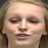

In [28]:
pil_image

In [29]:
to_model.shape

(1, 48, 48, 3)

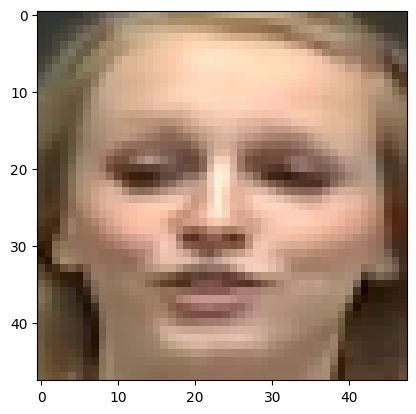

In [31]:
plt.imshow(to_model[0])

In [32]:
model.model(to_model)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[3.0910084e-04, 9.8762649e-01, 1.2064458e-02]], dtype=float32)>

In [36]:
model.get_emotion('uploads/test/img/crops/face/video_1.jpg')

array([3.0910084e-04, 9.8762649e-01, 1.2064458e-02], dtype=float32)

In [37]:
sum(model.get_emotion('uploads/test/img/crops/face/video_1.jpg'))

1.000000051688403

In [29]:
model.analyse_emotion('uploads/test/img/crops/face')

uploads/test/img/crops/facevideo_1.jpg
uploads/test/img/crops/facevideo_10.jpg
uploads/test/img/crops/facevideo_2.jpg
uploads/test/img/crops/facevideo_3.jpg
uploads/test/img/crops/facevideo_4.jpg
uploads/test/img/crops/facevideo_5.jpg
uploads/test/img/crops/facevideo_6.jpg
uploads/test/img/crops/facevideo_7.jpg
uploads/test/img/crops/facevideo_8.jpg
uploads/test/img/crops/facevideo_9.jpg


('neutral',
 ['neutral',
  'neutral',
  'sad',
  'happy',
  'happy',
  'neutral',
  'fear',
  'neutral',
  'sad',
  'sad'],
 [{'angry': 0.026952071,
   'disgust': 3.3114443e-06,
   'fear': 0.04647292,
   'happy': 0.0010000556,
   'neutral': 0.74368906,
   'sad': 0.18170615,
   'surprise': 0.00017645482},
  {'angry': 0.00598501,
   'disgust': 2.6504136e-08,
   'fear': 0.019079035,
   'happy': 7.7492135e-05,
   'neutral': 0.8727128,
   'sad': 0.102134235,
   'surprise': 1.1328599e-05},
  {'angry': 0.03692203,
   'disgust': 0.00027440983,
   'fear': 0.09771531,
   'happy': 0.0028511651,
   'neutral': 0.1370125,
   'sad': 0.72422576,
   'surprise': 0.0009988273},
  {'angry': 9.94471e-09,
   'disgust': 2.7109953e-17,
   'fear': 8.409566e-08,
   'happy': 0.99999845,
   'neutral': 1.4341771e-06,
   'sad': 3.3089805e-08,
   'surprise': 3.176606e-08},
  {'angry': 0.0022087698,
   'disgust': 7.3140285e-07,
   'fear': 0.005330407,
   'happy': 0.9560441,
   'neutral': 0.020052463,
   'sad': 0.0156